# Sentiment Analysis

## Dependencies

In [1]:
import re

import numpy as np
import pandas as pd

# Visualization
import seaborn as sns

# Google cloud
from google.oauth2 import service_account
from google.cloud import bigquery

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.optimizer_v2.adagrad import Adagrad
from keras.layers import Embedding, Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.losses import BinaryCrossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models import Word2Vec

## Loading Data

In [2]:
key_path = '../airflow/credentials/future-data-track-1-sapporo.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bigquery_client = bigquery.Client(
    project='future-data-track-1',
    credentials=credentials
)

In [3]:
query = """
WITH t AS (
  SELECT *
  FROM `future-data-track-1.sapporo_mart.sentiment_analysis`
),
table_stats AS (
  SELECT *, SUM(c) OVER() total 
  FROM (
    SELECT rating, COUNT(*) c 
    FROM t
    GROUP BY 1 
    HAVING c>10000)
)
SELECT sample.*
FROM (
SELECT ARRAY_AGG(a ORDER BY RAND() LIMIT 50000) cat_samples, rating, ANY_VALUE(c) c
FROM t a
JOIN table_stats b
USING(rating)
WHERE sentiment != 1
GROUP BY rating
), UNNEST(cat_samples) sample WITH OFFSET off;
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()

In [4]:
df.head()

,review,rating,sentiment
0,Love shopee,5,2
1,"Aplikasi Jual beli BUKALAPAK sangat membantu,,",5,2
2,banyak fiturnya,5,2
3,Banyak promo tapi sayang sekarang cod jarang p...,5,2
4,jos pindah sini aja yg diskonnya rame ��,5,2


In [5]:
df.isna().sum()

review       2
rating       0
sentiment    0
dtype: int64

In [6]:
df = df.dropna(axis=0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199998 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     199998 non-null  object
 1   rating     199998 non-null  int64 
 2   sentiment  199998 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.1+ MB


### Preprocessing

In [9]:
def preprocessing_text(texts):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    texts = list(filter(lambda x: x, [x.lower() for x in texts.split(" ")]))

    return texts

In [10]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

In [11]:
df.head()

,review,rating,sentiment,review_cleaned
0,Love shopee,5,2,"[love, shopee]"
1,"Aplikasi Jual beli BUKALAPAK sangat membantu,,",5,2,"[aplikasi, jual, beli, bukalapak, sangat, memb..."
2,banyak fiturnya,5,2,"[banyak, fiturnya]"
3,Banyak promo tapi sayang sekarang cod jarang p...,5,2,"[banyak, promo, tapi, sayang, sekarang, cod, j..."
4,jos pindah sini aja yg diskonnya rame ��,5,2,"[jos, pindah, sini, aja, yg, diskonnya, rame]"


In [12]:
word_length = []
for row in df['review_cleaned']:
    word_length.append(len(row))

print(pd.DataFrame(word_length, columns=['word_length']).describe())
print(pd.DataFrame(word_length, columns=['word_length']).quantile(0.90))

         word_length
count  199998.000000
mean       11.021680
std        13.930243
min         0.000000
25%         2.000000
50%         6.000000
75%        14.000000
max       194.000000
word_length    28.0
Name: 0.9, dtype: float64


In [13]:
tokenizer = Tokenizer(num_words=10000)

In [14]:
tokenizer.fit_on_texts(df['review_cleaned'])
seq = tokenizer.texts_to_sequences(df['review_cleaned'])
X = pad_sequences(seq, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (199998, 193), X_min: 0, X_max: 9999


In [15]:
y = df['sentiment'].map({0:0, 2:1})

### Train-test split

In [16]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(127998, 193) (32000, 193) (40000, 193) (127998,) (32000,) (40000,)


## Prepare Embedding

In [17]:
embedding = Word2Vec(df['review_cleaned'], vector_size=100, window=5, workers=2, min_count=2)

In [18]:
words = len(embedding.wv)
print('Vocabulary size: %d' % words)

Vocabulary size: 24889


In [19]:
def get_weight_matrix(embedding: Word2Vec, vocab):
    vocab_size = len(vocab) + 1

    weight_matrix = np.zeros((vocab_size, 100))

    for word, i in vocab.items():
        try:
            weight_matrix[i] = embedding.wv.get_vector(word)
        except:
            continue
    
    return weight_matrix

In [20]:
embedding_vectors = get_weight_matrix(embedding, tokenizer.word_index)

In [21]:
vocab_size = len(tokenizer.word_index) + 1
max_length = X.shape[1]

## Create Model Layers

In [22]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_vectors], input_length=max_length, trainable=True),
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', strides=2),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 100)          6200800   
_________________________________________________________________
conv1d (Conv1D)              (None, 97, 128)           64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6145      
Total params: 6,271,073
Trainable params: 6,271,073
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [23]:
optimizer = Adagrad(learning_rate=0.01)
model.compile(loss=BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_valid, y_valid))

Epoch 1/15
4000/4000 [==============================] - 129s 32ms/step - loss: 0.4167 - accuracy: 0.8252 - val_loss: 0.3954 - val_accuracy: 0.8374
Epoch 2/15
4000/4000 [==============================] - 127s 32ms/step - loss: 0.3838 - accuracy: 0.8415 - val_loss: 0.3867 - val_accuracy: 0.8426
Epoch 3/15
4000/4000 [==============================] - 127s 32ms/step - loss: 0.3710 - accuracy: 0.8468 - val_loss: 0.3824 - val_accuracy: 0.8444
Epoch 4/15
4000/4000 [==============================] - 127s 32ms/step - loss: 0.3615 - accuracy: 0.8514 - val_loss: 0.3818 - val_accuracy: 0.8450
Epoch 5/15
4000/4000 [==============================] - 127s 32ms/step - loss: 0.3536 - accuracy: 0.8541 - val_loss: 0.3809 - val_accuracy: 0.8442
Epoch 6/15
4000/4000 [==============================] - 133s 33ms/step - loss: 0.3465 - accuracy: 0.8570 - val_loss: 0.3813 - val_accuracy: 0.8442
Epoch 7/15
4000/4000 [==============================] - 151s 38ms/step - loss: 0.3400 - accuracy: 0.8606 - val_loss: 0

<AxesSubplot:>

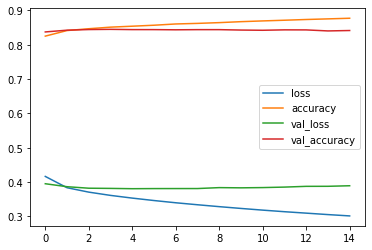

In [24]:
pd.DataFrame(history.history).plot()

              precision    recall  f1-score   support

           0       0.86      0.82      0.84     19999
           1       0.83      0.87      0.85     20001

    accuracy                           0.84     40000
   macro avg       0.84      0.84      0.84     40000
weighted avg       0.84      0.84      0.84     40000



<AxesSubplot:>

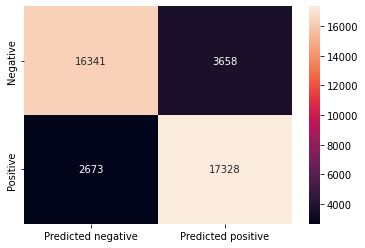

In [25]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])